## The Research Example in Chapter 6, Section 5: An Exoplanet Transit

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
imlist = []
jd = []

for i in range(1237):
    fn = f'../../BookDatasets/TESS/HAT-P-11/{i}.fits'
    imlist.append(fits.getdata(fn))
    jd.append(fits.getheader(fn)['btjd'])

imlist = np.array(imlist)
jd = np.array(jd)

In [3]:
print(jd)
print(jd.shape)
print(imlist.shape)

[1683.36712646 1683.38800049 1683.40881348 ... 1710.13824463 1710.15905762
 1710.17987061]
(1237,)
(1237, 20, 20)


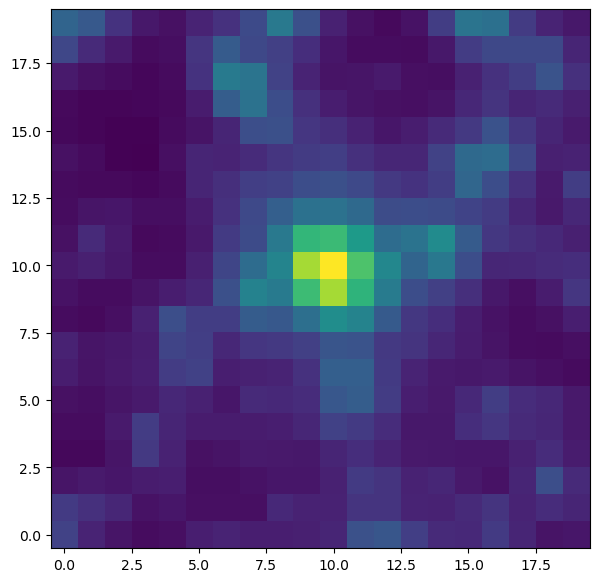

In [4]:
fix, ax = plt.subplots(figsize=(7,7))
ax.imshow(np.log10(imlist[0]), origin='lower')

### Exercise 6.1

In [5]:
# 6.1.1: Create a subarray of the 3rd through 10th image, but only for the
# first three rows and columns of those images.

subimlist = imlist[3:11,0:3,0:3]

print(subimlist.shape)

(8, 3, 3)


In [6]:
# 6.1.2: Create a subarray of the central 5x5 pixels, but only for images
# with even numbered indices.

central_imlist = imlist[::2,8:13,8:13] # leaves out pixels 0 to 7 and 13 to 19

print(central_imlist.shape)

(619, 5, 5)


### Cropping and Summing

In [7]:
cropped_array = imlist[:,8:13,8:13]
flux = np.sum(cropped_array, axis=(1,2))
flux.shape

(1237,)

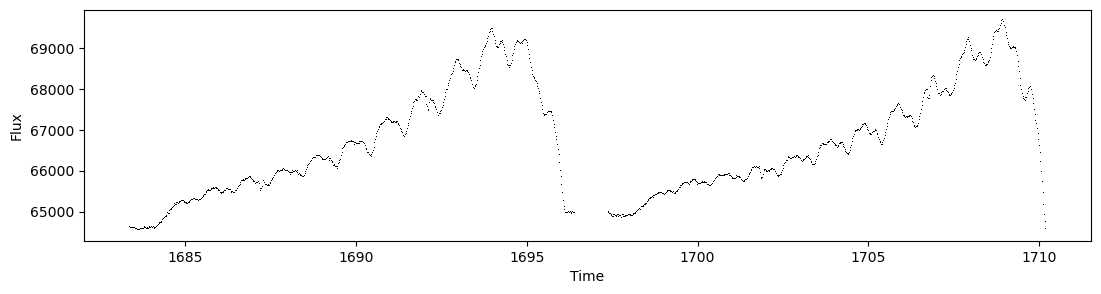

In [8]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(jd, flux, 'k,')
ax.set_xlabel('Time')
ax.set_ylabel('Flux');

### Background Subtraction

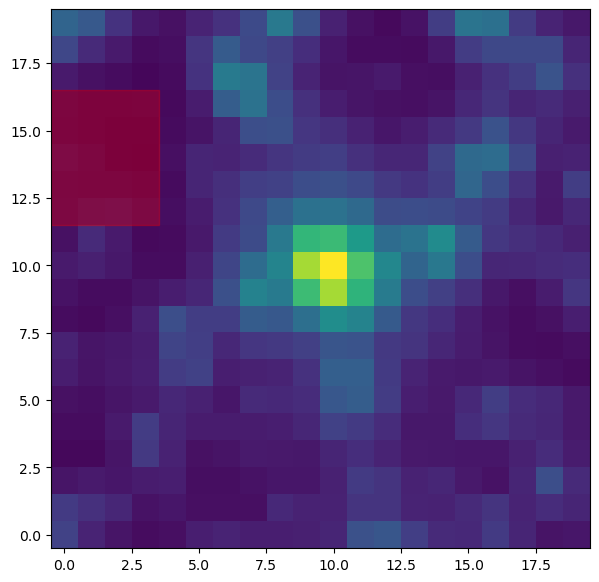

In [9]:
bg = imlist[:,0:4,12:17]
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(np.log10(imlist[0]), origin='lower')
ax.fill_between([-0.5,3.5], 11.5, 16.5, color='r', alpha=0.3);

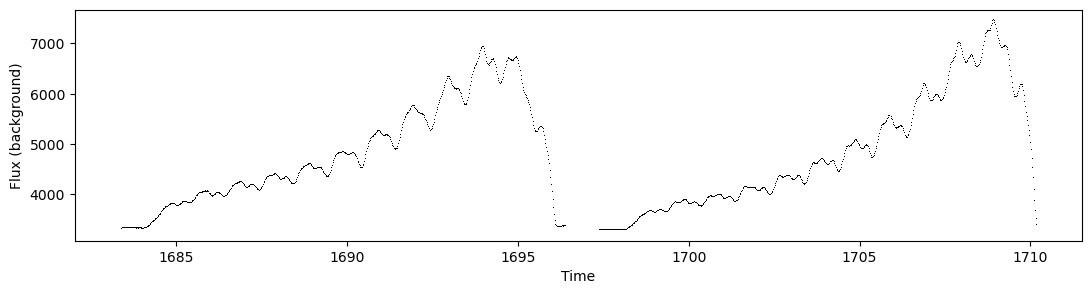

In [10]:
flux_bg = np.sum(bg, axis=(1,2))
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(jd, flux_bg, 'k,')
ax.set_xlabel('Time')
ax.set_ylabel('Flux (background)');

In [11]:
mean_bg = np.mean(bg, axis=(1,2))
flux_minus_bg = flux - mean_bg * cropped_array[0].size

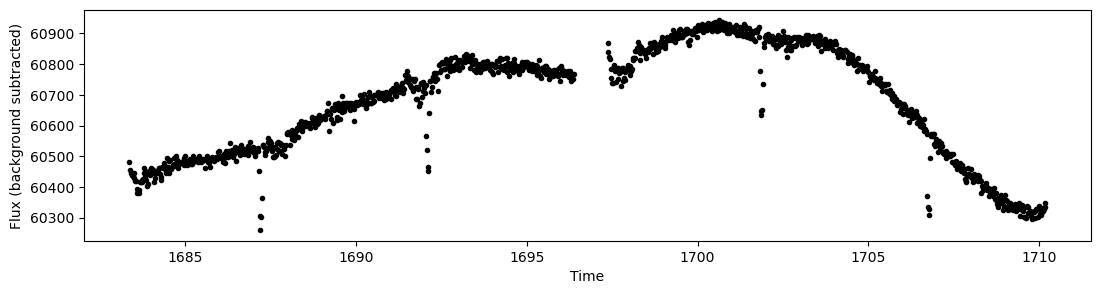

In [12]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(jd, flux_minus_bg, '.', color='k')
ax.set_xlabel('Time')
ax.set_ylabel('Flux (background subtracted)');

### Phase Folding

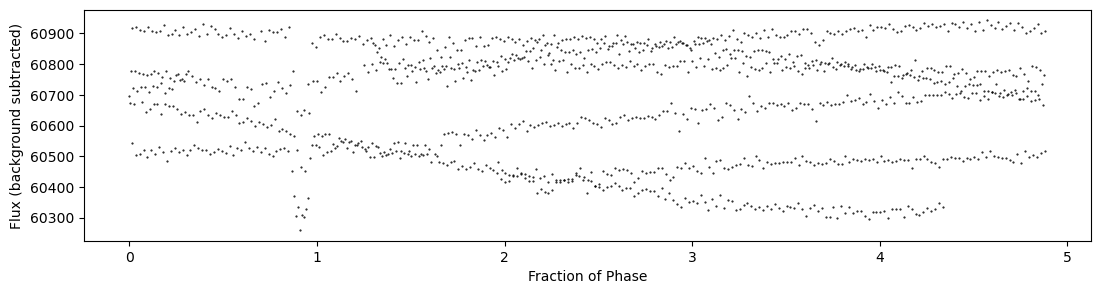

In [13]:
period_days = 4.887802443
folded_time = (jd % period_days)
fix, ax = plt.subplots(figsize=(13,3))
ax.plot(folded_time, flux_minus_bg, '.', color='k', ms=1)
ax.set_xlabel('Fraction of Phase')
ax.set_ylabel('Flux (background subtracted)');

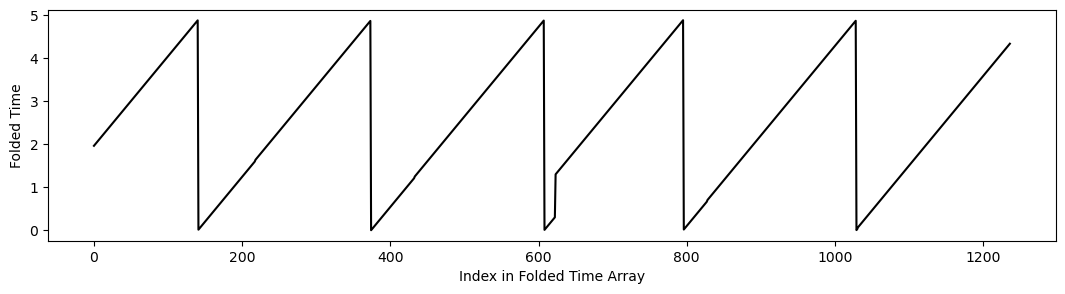

In [14]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(folded_time, color='k', ms=1)
ax.set_xlabel('Index in Folded Time Array')
ax.set_ylabel('Folded Time');

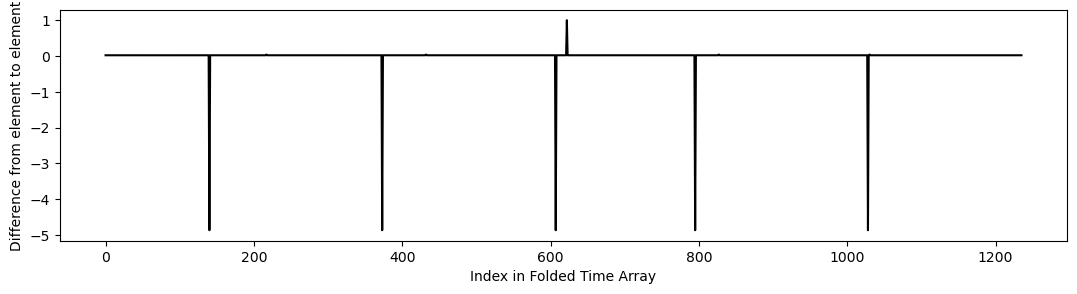

In [15]:
difference_array = folded_time[1:] - folded_time[:-1]
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(difference_array, color='k', ms=1)
ax.set_xlabel('Index in Folded Time Array')
ax.set_ylabel('Difference from element to element');

In [16]:
ind, = np.where(difference_array<0)
ind

array([ 140,  373,  607,  795, 1028])

In [17]:
print(folded_time[140])
print(folded_time[141])

4.879834119718751
0.012844665000001143


In [18]:
composite_array = np.array([folded_time, flux_minus_bg])
chunk1 = composite_array[:,:141]
chunk2 = composite_array[:,141:374]
chunk3 = composite_array[:,374:608]
chunk4 = composite_array[:,608:796]
chunk5 = composite_array[:,796:1029]
chunk6 = composite_array[:,1029:]

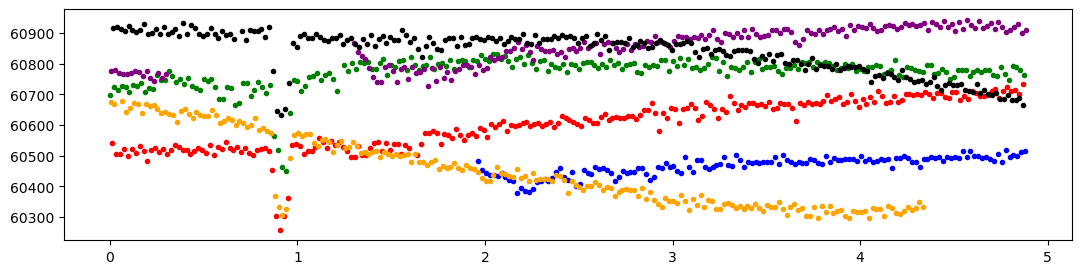

In [19]:
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(chunk1[0], chunk1[1], '.', color='blue')
ax.plot(chunk2[0], chunk2[1], '.', color='red')
ax.plot(chunk3[0], chunk3[1], '.', color='green')
ax.plot(chunk4[0], chunk4[1], '.', color='purple')
ax.plot(chunk5[0], chunk5[1], '.', color='black')
ax.plot(chunk6[0], chunk6[1], '.', color='orange');

In [20]:
chunk2_norm = chunk2[1] / np.mean(chunk2[1,:20])
chunk3_norm = chunk3[1] / np.mean(chunk3[1,:20])
chunk5_norm = chunk5[1] / np.mean(chunk5[1,:20])

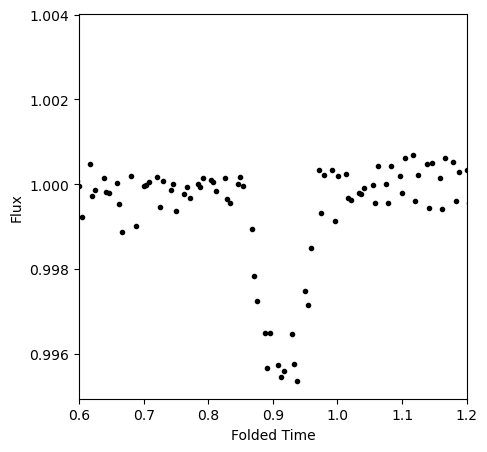

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(chunk2[0], chunk2_norm, '.', color='black')
ax.plot(chunk3[0], chunk3_norm, '.', color='black')
ax.plot(chunk5[0], chunk5_norm, '.', color='black')
ax.set_xlabel('Folded Time')
ax.set_ylabel('Flux')
ax.set_xlim(0.6, 1.2);

### Making a Single Chronological Array

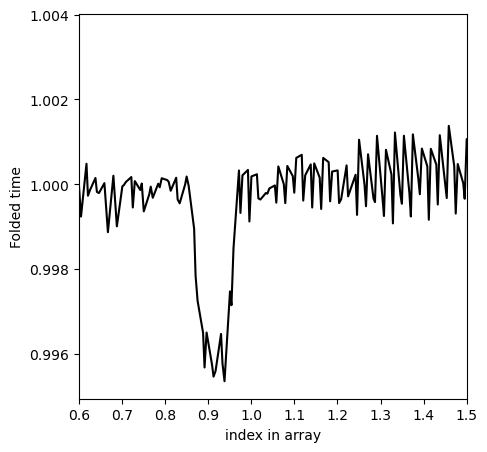

In [24]:
final_transit_fluxes = np.concatenate([chunk2_norm, chunk3_norm, chunk5_norm])
final_transit_times = np.concatenate([chunk2[0], chunk3[0], chunk5[0]])
final_transit = np.array([final_transit_times, final_transit_fluxes]).T

final_transit_sorted = final_transit[final_transit[:,0].argsort()]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(final_transit_sorted[:,0], final_transit_sorted[:,1], color='k')
ax.set_xlim(0.6, 1.5)
ax.set_xlabel('index in array')
ax.set_ylabel('Folded time');

### Estimating Noise

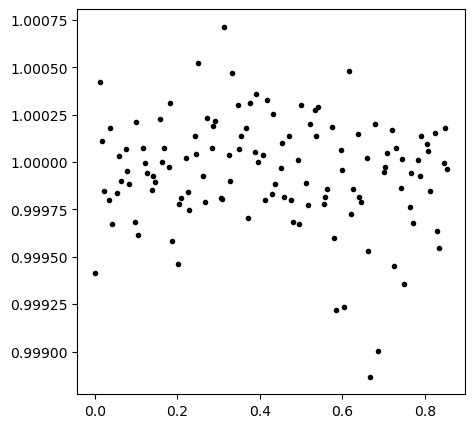

In [25]:
beginning_elements = final_transit_sorted[:123,:]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(beginning_elements[:,0], beginning_elements[:,1], '.', color='k')

In [26]:
std = np.std(beginning_elements[:,1])
print(f'Noise: {std}')

Noise: 0.00028693376279735226


In [27]:
transit_depth_by_eyeball = 0.005

transit_depth_by_eyeball / std

17.425624476026766